In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d
import tushare as ts

In [12]:
#calculate the co-intergation
from statsmodels.tsa.stattools import coint
Stock = ts.get_k_data('000001', start='2015-01-01', end='2016-12-31', ktype='D',autype='qfq')
Stock.index = pd.to_datetime(Stock['date'],format='%Y-%m-%d')
HS300 =ts.get_k_data('hs300', start='2015-01-01', end='2016-12-31', ktype='D',autype='qfq')
HS300.index = pd.to_datetime(HS300['date'],format='%Y-%m-%d')

data = pd.concat([HS300.close, Stock.close], keys=['HS300', 'Stock'], axis=1)

_, pvalue, _ = coint(data.HS300, data.Stock)
print pvalue

0.0119842798289


In [13]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
observation_matrices = [1],
initial_state_mean = 6,
initial_state_covariance = 1,
observation_covariance=1,
transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(Stock.close.values)
state_means = pd.Series(state_means.flatten(), index=Stock.index)

print state_means.tail()

date
2016-12-26    9.284338
2016-12-27    9.264901
2016-12-28    9.245410
2016-12-29    9.229675
2016-12-30    9.217340
dtype: float64


D:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  if __name__ == '__main__':
D:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  from ipykernel import kernelapp as app
D:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
  app.launch_new_instance()


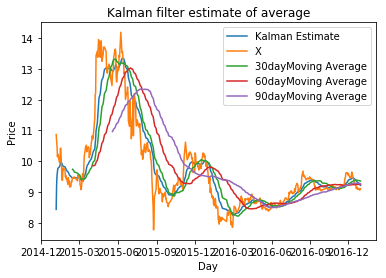

In [14]:
mean30 = pd.rolling_mean(Stock.close, 30)
mean60 = pd.rolling_mean(Stock.close, 60)
mean90 = pd.rolling_mean(Stock.close, 90)

plt.plot(state_means[:])
plt.plot(Stock.close[:])
plt.plot(mean30[:])
plt.plot(mean60[:])
plt.plot(mean90[:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30dayMoving Average', '60dayMoving Average','90dayMoving Average'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [16]:
# Load index data

x = Stock.close
y = HS300.close

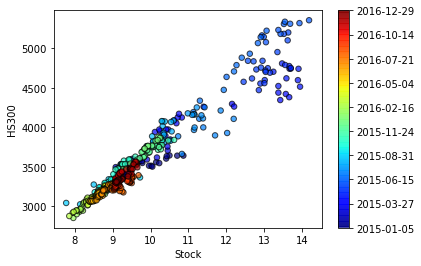

In [17]:
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('Stock')
plt.ylabel('HS300')
plt.show()

In [18]:
delta = 1e3
trans_cov = delta / (1-delta)* np.eye(2) # How much random walk wiggles
# print 'trans_cov', trans_cov

obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
# print 'obs_mat:', obs_mat

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1dimensional,(alpha, beta) is 2dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

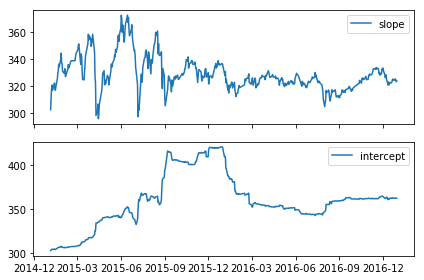

In [19]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)

# print state_means

_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout()
plt.show()

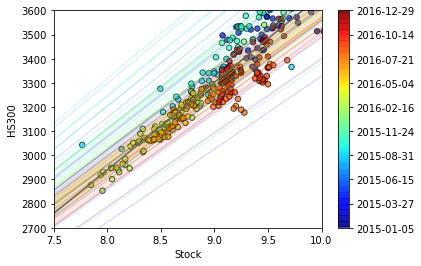

In [20]:
# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x.min()-5,x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))

for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')
# Adjust axes for visibility
plt.axis([7.5, 10, 2700, 3600])
# Label axes
plt.xlabel('Stock')
plt.ylabel('HS300')
plt.show()

In [21]:
import talib as ta
HS300_close = HS300.close
Stock_close = Stock.close
data = pd.concat([HS300_close, Stock_close], keys=['HS300','Stock'], axis=1)
data['slope'] = list(state_means[:,0])
data['Price_diff'] = data['HS300']-data['slope']*data['Stock']
data['mean'] = ta.MA(data.Price_diff.values, 50)
data['std'] = ta.STDDEV(data.Price_diff.values, 50)

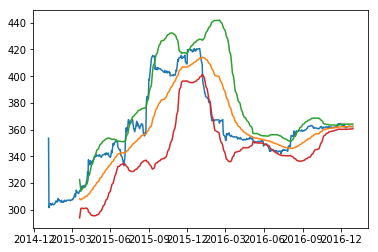

In [22]:
plt.plot(data['Price_diff'])
plt.plot(data['mean'])
plt.plot(data['mean']+2*data['std'])
plt.plot(data['mean']-2*data['std'])
plt.show()

可以做多价差，在橘色线上时候做多大盘，做空股票；反之亦然。

可以做价差的波动反转，在上边界穿越后下破上边界，做多股票，做空大盘。